In [141]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
import skfuzzy as fuzz

ModuleNotFoundError: No module named 'skfuzzy'

In [ ]:
df = pd.read_csv('../data/credit_card_data.csv')

In [ ]:
print(df.head())
print(df.info())

  CUST_ID      BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0  C10001    40.900749           0.818182      95.40              0.00   
1  C10002  3202.467416           0.909091       0.00              0.00   
2  C10003  2495.148862           1.000000     773.17            773.17   
3  C10004  1666.670542           0.636364    1499.00           1499.00   
4  C10005   817.714335           1.000000      16.00             16.00   

   INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0                    95.4      0.000000             0.166667   
1                     0.0   6442.945483             0.000000   
2                     0.0      0.000000             1.000000   
3                     0.0    205.788017             0.083333   
4                     0.0      0.000000             0.083333   

   ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
0                    0.000000                          0.083333   
1                    0.000000       

In [ ]:
print(df.describe())
print(df.isnull().sum())

            BALANCE  BALANCE_FREQUENCY     PURCHASES  ONEOFF_PURCHASES  \
count   8950.000000        8950.000000   8950.000000       8950.000000   
mean    1564.474828           0.877271   1003.204834        592.437371   
std     2081.531879           0.236904   2136.634782       1659.887917   
min        0.000000           0.000000      0.000000          0.000000   
25%      128.281915           0.888889     39.635000          0.000000   
50%      873.385231           1.000000    361.280000         38.000000   
75%     2054.140036           1.000000   1110.130000        577.405000   
max    19043.138560           1.000000  49039.570000      40761.250000   

       INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
count             8950.000000   8950.000000          8950.000000   
mean               411.067645    978.871112             0.490351   
std                904.338115   2097.163877             0.401371   
min                  0.000000      0.000000             0.000

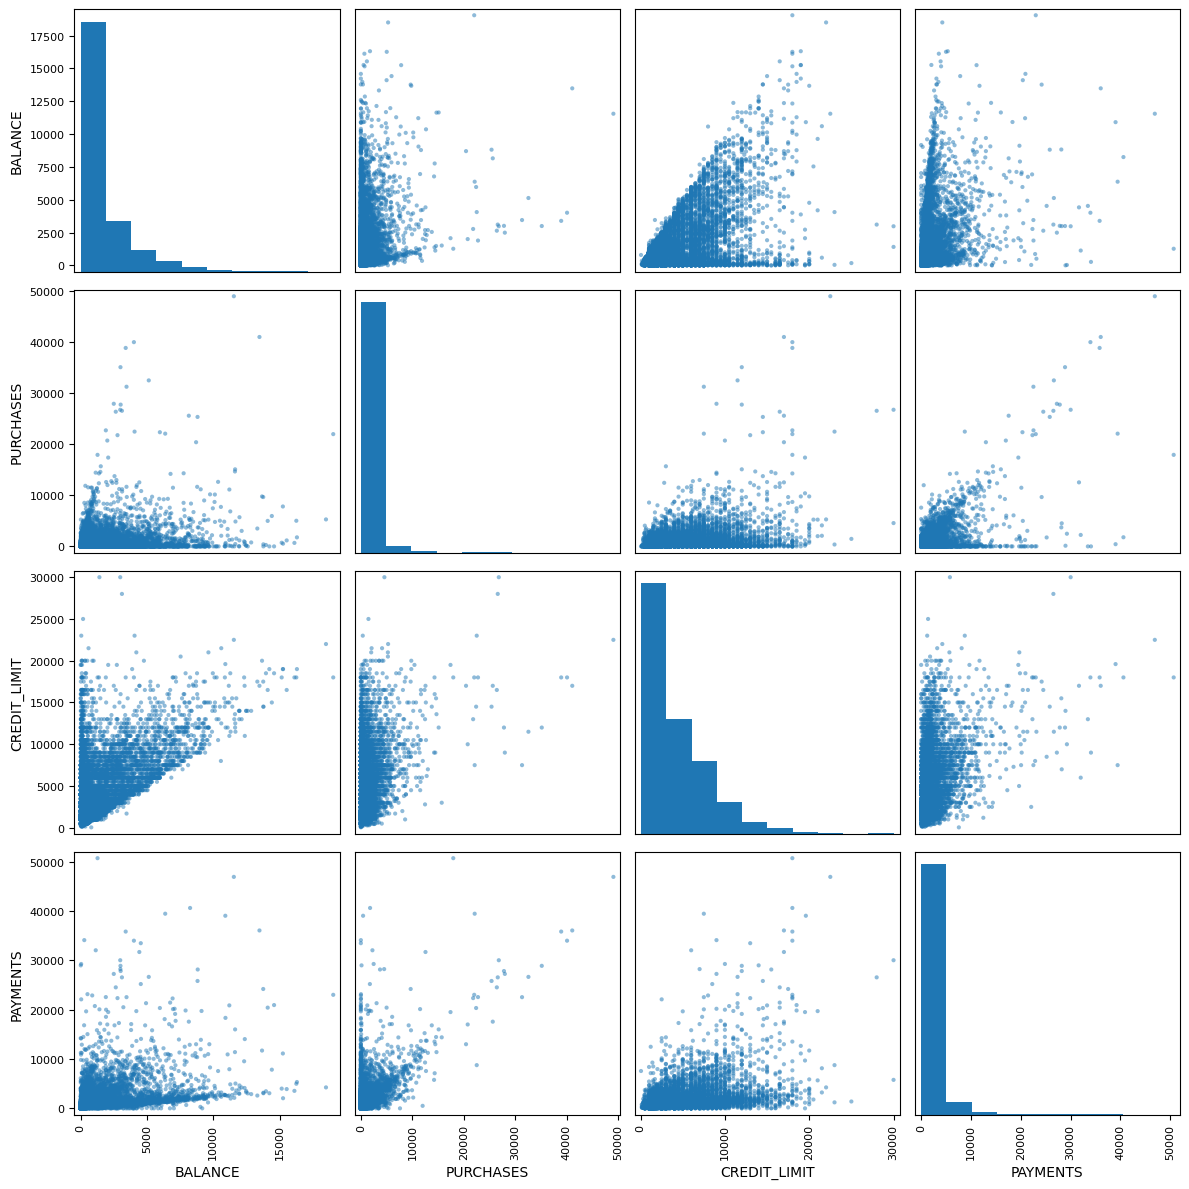

In [ ]:
from pandas.plotting import scatter_matrix

colonnes_importantes = ['BALANCE', 'PURCHASES', 'CREDIT_LIMIT', 'PAYMENTS']
scatter_matrix(df[colonnes_importantes], figsize=(12, 12))
plt.tight_layout()
plt.show()

In [ ]:
features = df.select_dtypes(include=['float64', 'int64']).columns
X = df[features].copy()

# Gestion des valeurs manquantes
X = X.fillna(X.mean())

# Standardisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Application PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)

Variance expliquée: [0.27290037 0.20301991]


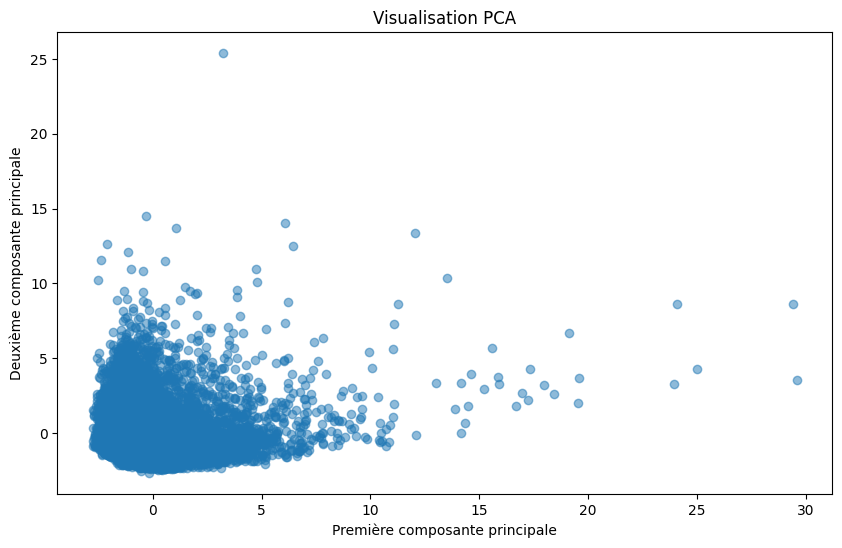

In [ ]:
# Visualisation PCA
plt.figure(figsize=(10, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.5)
plt.xlabel('Première composante principale')
plt.ylabel('Deuxième composante principale')
plt.title('Visualisation PCA')
print("Variance expliquée:", pca.explained_variance_ratio_)
plt.show()

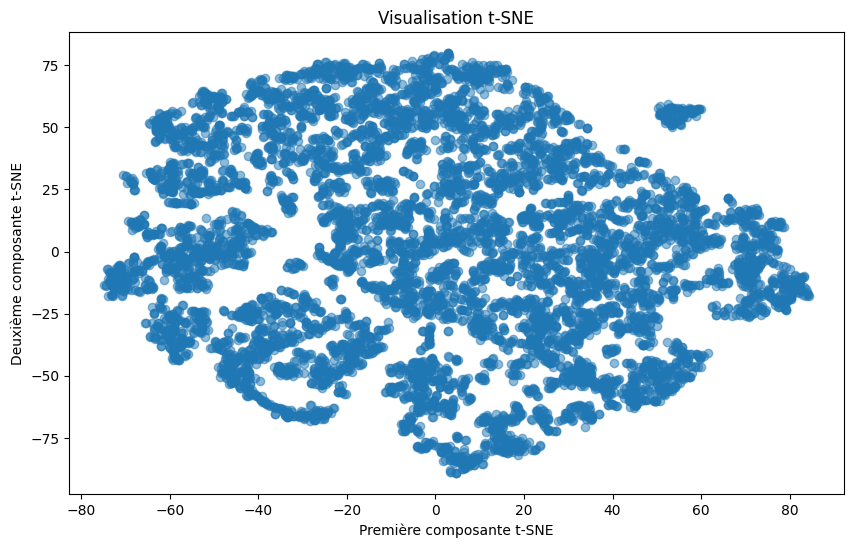

In [ ]:
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], alpha=0.5)
plt.xlabel('Première composante t-SNE')
plt.ylabel('Deuxième composante t-SNE')
plt.title('Visualisation t-SNE')
plt.show()

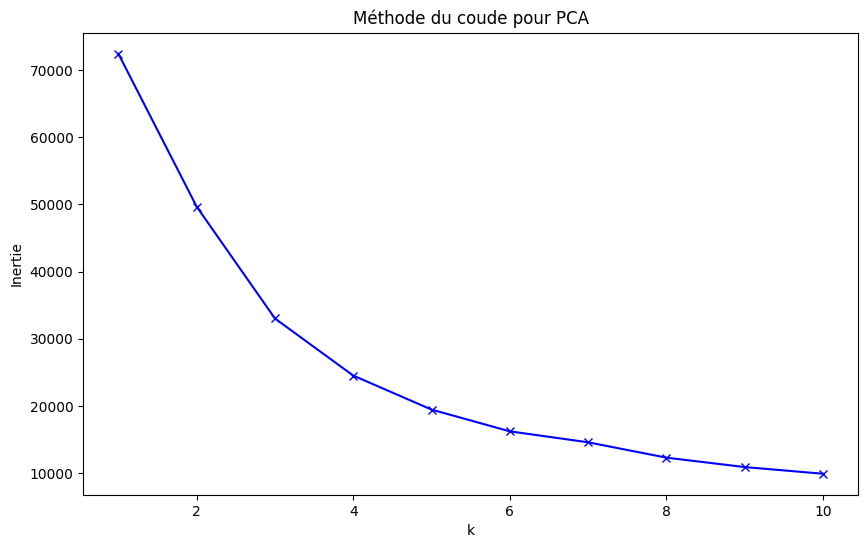

In [ ]:
#kmeans avec PCA
inertias_pca = []
K = range(1, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_result)
    inertias_pca.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(K, inertias_pca, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertie')
plt.title('Méthode du coude pour PCA')
plt.show()

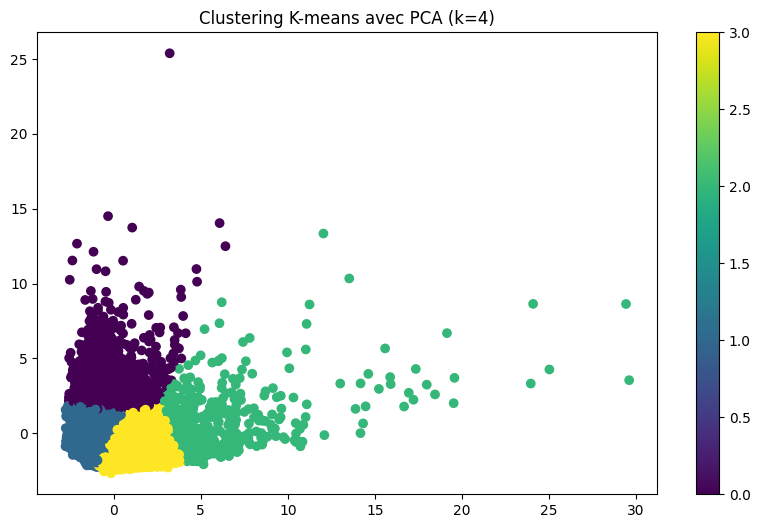

In [ ]:
# K-means avec nombre optimal de clusters
n_clusters = 4  # à ajuster selon le graphique
kmeans_pca = KMeans(n_clusters=n_clusters, random_state=42)
clusters_pca = kmeans_pca.fit_predict(pca_result)

# Visualisation des clusters
plt.figure(figsize=(10, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=clusters_pca, cmap='viridis')
plt.title(f'Clustering K-means avec PCA (k={n_clusters})')
plt.colorbar()
plt.show()

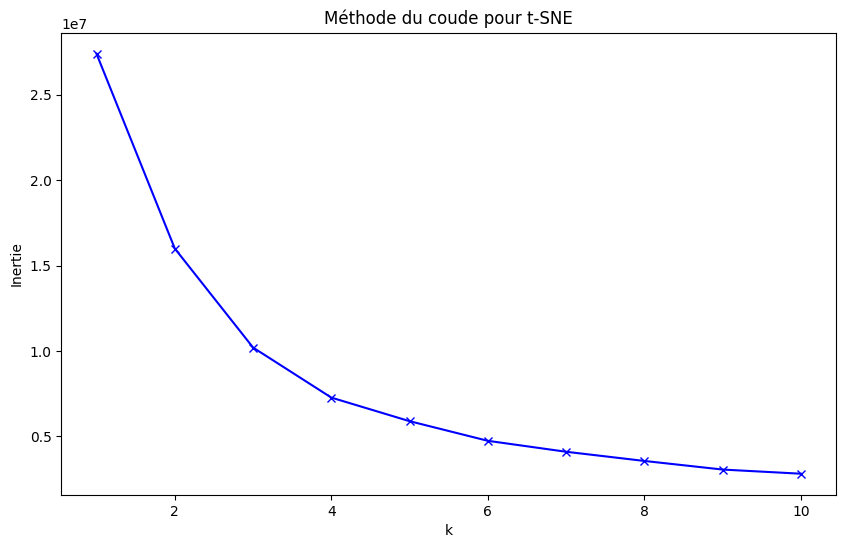

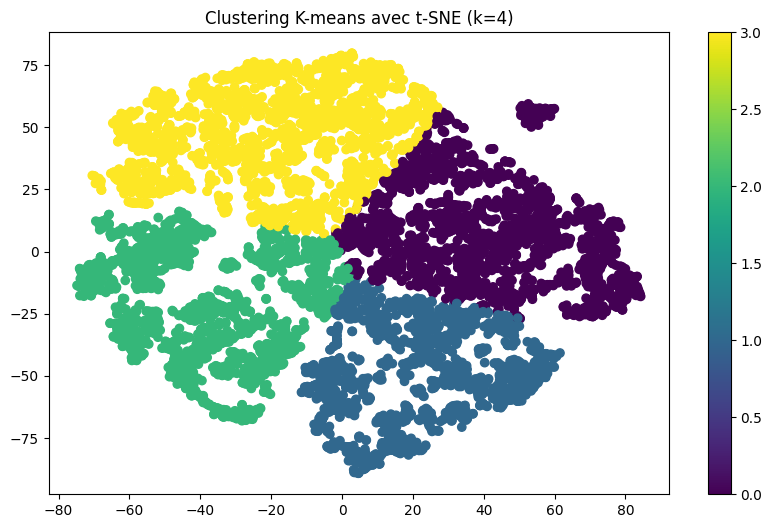

In [ ]:
inertias_tsne = []
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(tsne_result)
    inertias_tsne.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(K, inertias_tsne, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertie')
plt.title('Méthode du coude pour t-SNE')
plt.show()

kmeans_tsne = KMeans(n_clusters=n_clusters, random_state=42)
clusters_tsne = kmeans_tsne.fit_predict(tsne_result)

plt.figure(figsize=(10, 6))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=clusters_tsne, cmap='viridis')
plt.title(f'Clustering K-means avec t-SNE (k={n_clusters})')
plt.colorbar()
plt.show()

In [143]:
def soft_clustering_kmeans(data, n_clusters, soft_factor=2):
    """
    Alternative au Fuzzy C-means utilisant K-means avec appartenances souples
    """
    # K-means standard
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(data)
    
    # Calcul des distances aux centroids
    distances = kmeans.transform(data)
    
    # Conversion en degrés d'appartenance
    memberships = 1 / (1 + (distances ** 2) / soft_factor)
    memberships = normalize(memberships, norm='l1', axis=1)
    
    # Labels basés sur l'appartenance maximale
    labels = np.argmax(memberships, axis=1)
    
    return memberships, labels, kmeans.cluster_centers_

# Application du clustering souple
memberships_pca, clusters_soft, centers = soft_clustering_kmeans(pca_result, n_clusters)

# Visualisation du clustering souple
plt.figure(figsize=(15, 5))

# Clusters basés sur l'appartenance maximale
plt.subplot(1, 2, 1)
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=clusters_soft, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='red', marker='x', s=200, linewidth=3)
plt.title('Clustering souple - Clusters')

# Degrés d'appartenance
plt.subplot(1, 2, 2)
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=memberships_pca[:, 0], cmap='coolwarm')
plt.colorbar(label='Degré d\'appartenance au cluster 1')
plt.title('Clustering souple - Degrés d\'appartenance')
plt.show()

NameError: name 'normalize' is not defined